In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

In [7]:
# Load the IMDb Movie Reviews dataset
dataset_path = '/content/IMDB Dataset.csv'
df = pd.read_csv(dataset_path)

In [8]:
# Display the first few rows of the dataset
print("Dataset Preview:")
print(df.head())

Dataset Preview:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [9]:
# Map 'positive' to 1 and 'negative' to 0
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

In [10]:
# Split the dataset into training and testing sets
train_size = int(0.8 * len(df))
train_data = df[:train_size]
test_data = df[train_size:]

In [11]:
# Tokenize and pad sequences
max_features = 10000
maxlen = 200
tokenizer = Tokenizer(num_words=max_features, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data['review'])
train_sequences = tokenizer.texts_to_sequences(train_data['review'])
test_sequences = tokenizer.texts_to_sequences(test_data['review'])

In [12]:
x_train = pad_sequences(train_sequences, maxlen=maxlen, padding='post', truncating='post')
x_test = pad_sequences(test_sequences, maxlen=maxlen, padding='post', truncating='post')
y_train = train_data['sentiment'].values
y_test = test_data['sentiment'].values

In [13]:
# Build the LSTM model
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

In [14]:
# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320000    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 328353 (1.25 MB)
Trainable params: 328353 (1.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
# Compile the model
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [16]:
# Train the model
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
250/250 [==============================] - 35s 130ms/step - loss: 0.6440 - accuracy: 0.6108 - val_loss: 0.5789 - val_accuracy: 0.6933
Epoch 2/10
250/250 [==============================] - 36s 142ms/step - loss: 0.5781 - accuracy: 0.7455 - val_loss: 0.5420 - val_accuracy: 0.7854
Epoch 3/10
250/250 [==============================] - 32s 128ms/step - loss: 0.4517 - accuracy: 0.8255 - val_loss: 0.5372 - val_accuracy: 0.7571
Epoch 4/10
250/250 [==============================] - 35s 139ms/step - loss: 0.3823 - accuracy: 0.8581 - val_loss: 0.3949 - val_accuracy: 0.8403
Epoch 5/10
250/250 [==============================] - 32s 127ms/step - loss: 0.2972 - accuracy: 0.8908 - val_loss: 0.3605 - val_accuracy: 0.8549
Epoch 6/10
250/250 [==============================] - 32s 127ms/step - loss: 0.2516 - accuracy: 0.9107 - val_loss: 0.3550 - val_accuracy: 0.8528
Epoch 7/10
250/250 [==============================] - 33s 133ms/step - loss: 0.2186 - accuracy: 0.9240 - val_loss: 0.3697 - val_ac

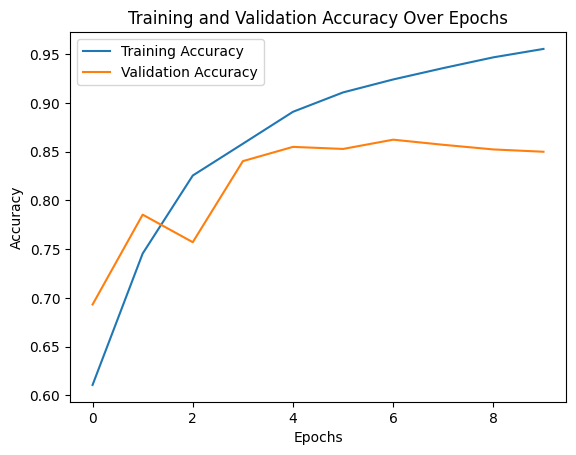

In [17]:
# Visualize training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

In [18]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

313/313 [==============================] - 8s 24ms/step - loss: 0.4018 - accuracy: 0.8553
Test accuracy: 0.8553


In [19]:
# Confusion matrix and classification report
y_pred = (model.predict(x_test) > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

313/313 [==============================] - 7s 20ms/step
Confusion Matrix:
[[4103  890]
 [ 557 4450]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      4993
           1       0.83      0.89      0.86      5007

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [20]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, model.predict(x_test))
roc_auc = auc(fpr, tpr)

313/313 [==============================] - 7s 23ms/step


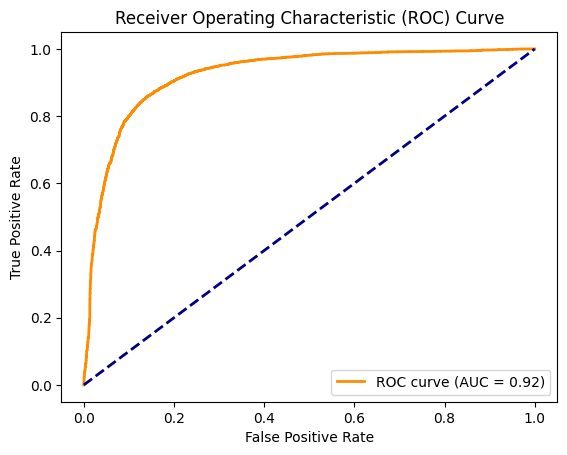

In [21]:
# Visualize ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
